In [1]:
import os
import yaml
import pickle
import numpy as np
import pandas as pd
import itertools
import scipy
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

from produce_dataset import *

In [2]:
df_econ = loadEconData('/ecoderemdvol/EleGun/EPGun-PU200/econ_ntuples/',
                       'FloatingpointAutoEncoderEMDAEMSEttbarDummyHistomaxGenmatchGenclustersntuple',
                       'econ_data.csv')
df_gen = loadGenData('/ecoderemdvol/EleGun/EPGun-PU200/econ_ntuples/',
                       'FloatingpointAutoEncoderEMDAEMSEttbarDummyHistomaxGenmatchGenclustersntuple',
                       'econ_data.csv')

In [3]:
df_econ

,ECON_0,ECON_1,ECON_2,ECON_3,ECON_4,ECON_5,ECON_6,ECON_7,ECON_8,ECON_9,...,ECON_14,ECON_15,subdet,zside,layer,waferu,waferv,wafer_energy,tc_eta,tc_phi
0,0,192,64,128,128,0,128,128,64,128,...,128,64,2,-1,33,1,2,0.054336,2.995116,1.568720
1,0,64,64,0,192,0,0,64,64,64,...,192,192,2,-1,32,3,5,0.062769,2.518934,1.704076
2,0,128,64,64,128,0,128,128,192,128,...,64,128,2,-1,32,3,4,0.052978,2.725063,1.900426
3,0,192,64,128,128,0,192,128,64,64,...,64,128,2,-1,31,2,4,0.074107,2.433419,1.564620
4,0,128,128,128,128,0,64,64,128,128,...,128,128,2,-1,30,3,5,0.036578,2.490556,1.713465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,0,192,320,64,64,0,128,64,128,64,...,64,64,2,1,29,-3,-5,0.333403,2.473247,-1.443713
168,0,192,64,64,128,0,192,64,128,128,...,64,128,2,1,30,-2,-4,0.212168,2.412570,-1.579053
169,0,64,128,64,128,0,128,64,128,64,...,192,128,2,1,30,-2,-3,0.258525,2.644853,-1.416147
170,0,192,128,128,128,0,64,192,192,64,...,64,64,2,1,30,-1,-2,0.114087,2.953387,-1.564804


In [4]:
df_gen

,pt,energy,eta,phi
0,80.423019,522.664307,2.558814,-1.537044
1,80.423019,522.664307,-2.558814,1.604549


In [5]:
df_nodes=df_econ[['ECON_0', 'ECON_1', 'ECON_2', 'ECON_3', 'ECON_4', 'ECON_5', 'ECON_6',
       'ECON_7', 'ECON_8', 'ECON_9', 'ECON_10', 'ECON_11', 'ECON_12','ECON_13', 'ECON_14', 'ECON_15', 
        'wafer_energy', 'tc_eta', 'tc_phi']]

In [6]:
embeddings = torch.tensor(df_nodes.values)

In [7]:
eta=df_nodes['tc_eta']
phi=df_nodes['tc_phi']
idx = range(len(eta))
indices_i = np.array([i for i,j in itertools.product(idx,idx)])
indices_j = np.array([j for i,j in itertools.product(idx,idx)])

In [8]:
del_R = np.empty([len(eta),len(eta)])

In [9]:
for (i, j) in zip(indices_i,indices_j):
    del_R[i][j]=np.sqrt((eta[i]-eta[j])**2+(phi[i]-phi[j])**2)

In [10]:
del_R = torch.tensor(del_R)

In [11]:
del_R

tensor([[0.0000, 0.4950, 0.4277,  ..., 3.0053, 3.1338, 3.5649],
        [0.4950, 0.0000, 0.2847,  ..., 3.1228, 3.2976, 3.6558],
        [0.4277, 0.2847, 0.0000,  ..., 3.3175, 3.4727, 3.8625],
        ...,
        [3.0053, 3.1228, 3.3175,  ..., 0.0000, 0.3425, 0.5774],
        [3.1338, 3.2976, 3.4727,  ..., 0.3425, 0.0000, 0.6533],
        [3.5649, 3.6558, 3.8625,  ..., 0.5774, 0.6533, 0.0000]],
       dtype=torch.float64)

In [12]:
adj = np.zeros([len(eta),len(eta)])
for (i, j) in zip(indices_i,indices_j):
    if del_R[i][j] <0.025 and  del_R[i][j]> 0 :
        adj[i][j]=1
adj=torch.tensor(adj)       

In [13]:
edge_index = (adj > 0).nonzero().t()
edge_index.shape

torch.Size([2, 440])

In [14]:
ys = torch.tensor(df_nodes['wafer_energy'])

In [15]:
graph = data.Data(x=embeddings, edge_index=edge_index, y=ys)

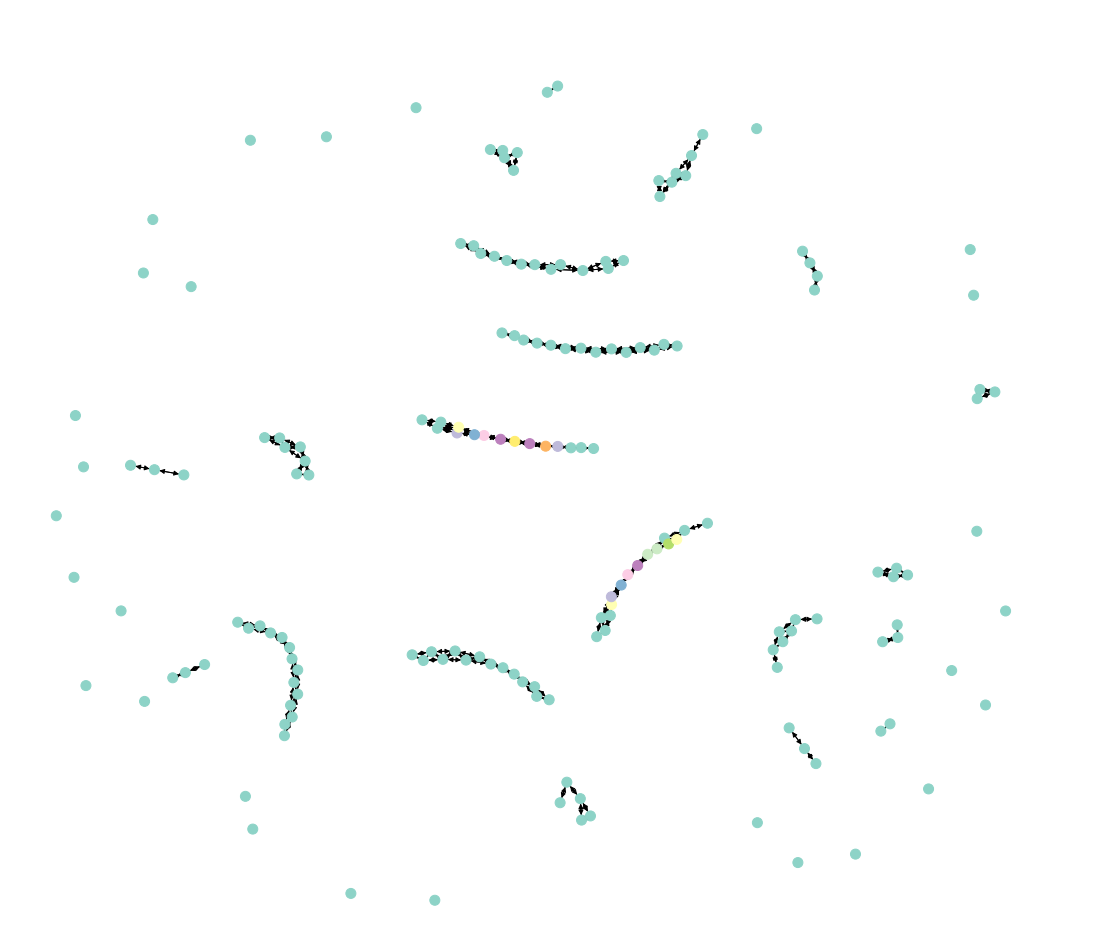

In [16]:
vis = to_networkx(graph)
#color per wafer_energy, could also make this sum of econ_charges
node_labels = graph.y.numpy()
plt.figure(1,figsize=(15,13)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color =node_labels,node_size=100,linewidths=1)
plt.show()